Michael Uftring   
Indiana University   
Network Science, Spring 2018   
Week#9 Assignment - Configuration Model

# Applying the configuration model

## Why random graphs?
In an early assignment we compared a BA network with an ER graph and saw that the degree distribution and shortest path length were quite different. If all we wanted to know was how the degree distributions were different than an ER graph isn't an unreasonable choice. However, as you learned in the reading and from looking at several different real world graphs you should be aware by now that most graphs don't have a simple poisson degree distribution. So while the ER graph is a simple model, it unfortunately isn't a good null model. 

Null models are often used in hypothesis testing to aid in the acceptance/rejection of some alternative hypothesis. The null, being the default assumption. In network science null models can also be used for statistical hypothesis testing and for determining whether certain graph features are responsible for some characteristic of the graph or some pattern of behavior on the graph (e.g. epidemic models or random walkers). 

The null model should match some of the real graph's topological characteristics but should otherwise be random. The configuration model allows us to hold the degree sequence constant while investigating other graph characteristics.

## Back to dolphins
Lets build a mock hypothesis using the [dolphin social network](http://www-personal.umich.edu/~mejn/netdata/dolphins.zip). My hypothesis is that dolphins have a posh and very exclusive culture. Popular dolphins only hang with other popular dolphins, while the loners are stuck to mingle among themselves. A sad state of affairs, but social life is hard in the pods. How might we test this?

There happens to be a similarity measure called [assortativity](https://en.wikipedia.org/wiki/Assortativity) where nodes of a certain type tend to be connected to nodes of the same type. In networkx there is a function called [degree assortativity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html?highlight=degree_assortativity_coefficient#networkx.algorithms.assortativity.degree_assortativity_coefficient) which tells us how strongly nodes of similar degree are attached to each other. If the network has high degree assortativity, then low degree nodes will be connected to other low degree nodes, and high degree nodes will be connected to other high degree nodes. Conversely, low degree assortativity (or even disassortativity) would imply no (or negative) relationship. 

Excellent, so we have a measure, but what do we compare our graph too? It wouldn't really be appropriate to compare it to an ER graph because the nodes all have different degrees which are about the same and normally distributed. Instead, we want to compare our dolphin network to a graph with the same degree distribution, and that is where the configuration model comes in.

## Testing the dolphin hypothesis
We are going to do a rough test for our hypothesis by calculating the z-score for our dolphin network's degree assortativity coefficient. We will do this by generating a bunch of configuration models based on the dolphin degree sequence and calculating the assortativity coefficient for those null graphs. We can then compare our real network with the null model. If our z-score is high then it is unlikely that the dolphin network's assortativity can be accounted for by just the degree-sequence of a random graph, which means something more interesting is at work.

Lets carry out this experiment:

In [1]:
# We should load networkx and scipy (which has statistical tools)
import networkx as nx
import scipy.stats as stats

In [2]:
# Lets load the dolphin social network
dolphin_net = nx.read_gml("dolphins.gml")

NetworkXError: cannot tokenize 'graph' at (2, 1)

In [3]:
# Used Gephi to convert Dolphin network from GML to Pajek (.net)
# Lets load the dolphin social network
dolphin_net = nx.read_pajek("dolphins.net")

In [4]:
# Often networkx will auto-load graphs as MultiGraphs
# I know this network is simple, so I will make sure it is of graph type Graph.
# Don't do this if your graph is directed. Directed graphs are of type DiGraph
dolphin_net = nx.Graph(dolphin_net)
print(type(dolphin_net).__name__)

Graph


Now that the graph is loaded in lets calculate the degree assortativity:

In [5]:
real_assortativity = nx.degree_assortativity_coefficient(dolphin_net)
print(real_assortativity)

-0.0435940282153


Interesting! So it appears that the network is disassortative, so it seems like our hypothesis about the dolphins is falling appart, but we still need to compare it to a null model in order to determine whether there is anything of interest to be pursued here.

Networkx has a [configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration_model) function that can be used to generate our null models. We can use it by passing it a degree sequence, which we will do using the dolphin network:

In [7]:
# nx.degree returns a dictionary, but all we want is a list of the
# degrees. We can get this by getting the dictionary values and
# converting those values to a list.
dolphin_degree_sequence = list(dict(nx.degree(dolphin_net)).values())

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
model_assortativity = []
for i in range(1000):
    # Use the configuration model to create a null graph
    null_graph = nx.configuration_model(dolphin_degree_sequence)
    
    # We need to remove self-loops and parallel edges because they don't make
    # sense in this social network
    null_graph = nx.Graph(null_graph) # removes parallel edges
    null_graph.remove_edges_from(null_graph.selfloop_edges()) # removes self-loops
    
    # Calculate the model's assortativity and add it to the list
    model_assortativity.append(nx.degree_assortativity_coefficient(null_graph))

Now we can calculate the z-scores using scipy's [zscore](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) function. It will print out the z-scores for all the elements of the distribution. If we assume that the dolphin network came from the null distribution then we can calculate the z-score for the dolphin network:

In [10]:
# Prepend the real assortativity to the model list and have scipy calculate the zscores
zscores = stats.zscore([real_assortativity] + model_assortativity)

# Just print out the first score which corresponds to the real network
print(zscores[0])

0.0588739711299


A z-score corresponds to how many standard deviations out from the mean the sample is. A score of +1 would be one standard deviation above the mean. Since the score is close to zero we can safely conclude that the disassortativity we observed in the dolphin network is explainable entirely from the degree sequence and no other special properties of the network.

However, this doesn't mean there aren't low-level features hidden in the network. The degree assortativity score is an aggregative measure, and it can obfuscate local deviations from assortativity that are non-random. There is also a score for the local degree assortativity, but we will not pursue that further here.

Now that we have a distribution of null assortativities we can also visualize the distribution and plot our dolphin network's assortativity along with it:

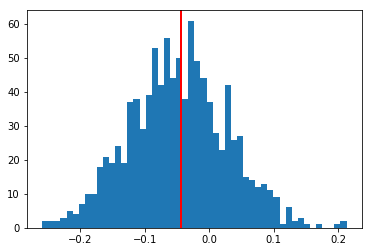

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(model_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(real_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

And there we have it! We have fair reason to conclude that not only is the hypothesis wrong but the surprising disassortativity we found really wasn't anything special after all. [note: reference for [`axvline`](http://matplotlib.org/api/pyplot_api.html?highlight=axvline#matplotlib.pyplot.axvline) in matplotlib]

# Assignment

1. Pick a graph of your choosing. You can use the graphs you are using for your project or any other real-world graph. Here are a couple places you can find some: [pajek datasets](http://vlado.fmf.uni-lj.si/pub/networks/data/), [Newman's datasets](http://www-personal.umich.edu/~mejn/netdata/). [note: if you use directed graphs makes sure you use the corresponding function [`directed_configuration_model`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.directed_configuration_model.html?highlight=configuration_model#networkx.generators.degree_seq.directed_configuration_model)]

2. Construct two simple hypotheses around two different measures that you can calculate from the graph. Here is a [list of algorithms that networkx has](https://networkx.github.io/documentation/stable/reference/algorithms/index.html). You aren't limited by measures networkx can calculate. However, do not use a measure that depends entirely on the degree sequence. For instance, it would be silly to compare average degree to the random networks generated by the configuration model because it uses the same degree sequence and so will have the same average degree.

3. Carry out a simple hypothesis test for both hypotheses. It can be similar to what I showed here. You are welcome to carry it out in a more robust manner, but the focus of this assignment is getting a hang of using configuration models as null models. Here is a link to [Statistics for Hackers](https://speakerd.s3.amazonaws.com/presentations/7e68b43159d646cf81eda9e1bded8213/Statistics_for_Hackers_-_PyCon2016.pdf). It has a nice little python tutorial for how you can carry out hypothesis testing without all the hard math. Even if you don't use it for this assignment I highly recommend checking it out.

4. Provide quantitative analysis and a graphical illustration of your results. It should be clear that your hypothesis was validated/invalidated/inconclusive.

5. Answer the following questions:
  * What graph are you using?
  * What are you hypotheses?
  * What measures will you be using to test your hypotheses? How do these measures accomplish this?
  * Explain your results. Were they surprising? Did they confirm or reject your hypotheses?
  * From these tests, what have you learned about the structure of the network you were investigating?

6. Once you are complete submit your Jupyter notebook to Canvas.

# Political Books

The network used in this assignment is the *Books about US Politics* found in [Newman's datasets](http://www-personal.umich.edu/~mejn/netdata/).

> A network of books about US politics published around the time of the 2004 presidential election and sold by the online bookseller Amazon.com. Edges between books represent frequent copurchasing of books by the same buyers. The network was compiled by V. Krebs and is unpublished, but can found on [Krebs' web site](http://www.orgnet.com). Thanks to Valdis Krebs for permission to post these data on this web site.

In [1]:
import networkx as nx
from numpy.random import choice, shuffle
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
# load the network: it was converted from Pajek to GraphmML (in Gephi)
# in order to retain the node attribute that designates the "politcal leaning"
# of the book: "l" = liberal, "n" = neutral, or "c" = conservative.
polbooks = nx.read_graphml("polbooks.graphml")

In [5]:
# obtain the degree sequence, for building graphs by Configuration Model
degree_seq = list(nx.degree(polbooks).values())

In [22]:
# obtain the `value` attribute, to be randomly applied to Configuration Model graphs
values = []
for node in polbooks.nodes():
    values.append(polbooks.node[node]['value'])

In [23]:
# a function to build Configuration Model graphs and calculate the following:
# - degree assortativity coefficient
# - attribute assortativity coefficient
# it returns two arrays, one for each of the calculated values
def models(degree_seq, value, values, iterations=1000):
    model_degree_assortativity = []
    model_attribute_assortativity = []
    for i in range(iterations):
        null_graph = nx.configuration_model(degree_seq)
        null_graph = nx.Graph(null_graph)
        data = values.copy()
        shuffle(data)
        count = 0
        for node in null_graph.nodes():
            null_graph.node[node][value] = data[count]
            count += 1
        model_degree_assortativity.append(nx.degree_assortativity_coefficient(null_graph))
        model_attribute_assortativity.append(nx.attribute_assortativity_coefficient(null_graph,value))
    return model_degree_assortativity, model_attribute_assortativity

## Assortativity Coefficient

The assortativity coefficient (`r`) value lies between −1 and 1. Positive values indicate a correlation between similarly measured nodes (e.g., by degree or attribute value), while negative values indicate relationships between dissimilar nodes. 

> When `r` = 1, the network is said to have perfect assortative mixing patterns   
> When `r` = 0 the network is non-assortative   
> When `r` = −1 the network is completely disassortative.   

**Reference:** [Assortativity (Wikipedia)](https://en.wikipedia.org/wiki/Assortativity)

## Hypothesis 1

**Popular Books Are Sold Together**

Very popular books are bought in mass together, while less popular books are bought together and not with the very popular ones. We will try to show this using *degree assortativity*, expecting high degree nodes will be connected to other high degree nodes (indicating popular books), and low degree nodes will be connected to other low degree nodes (indicating less popular books). 

In [24]:
degree_assortativity = nx.degree_assortativity_coefficient(polbooks)

In [25]:
degree_assortativity

-0.12789600966671899

The assortativity coefficient here is less than zero, and relatively close to zero which means that the network is non-assortative. This would indicate that the hypothesis is tending towards not being true. 

In [15]:
degree_model, attribute_model = models(degree_seq, 'value', values, iterations=1000)

In [16]:
zscores_degree = stats.zscore([degree_assortativity] + degree_model)
print(zscores_degree[0])

-1.99066421655


With a z-score of almost -2.0 for the real degree assortativity measure we can conclude that the non-assortative nature is significant, and we therefore reject the hypothesis. The popularity of a book purchase is not predicated by the prior (or cuncurrent) purchase of another popular title. Book purchase is intermixed.

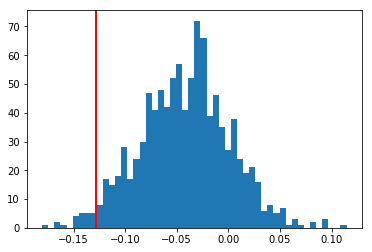

In [17]:
# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(degree_model, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(degree_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

## Hypothesis 2

**Political Boundaries Are Not Crossed**

Books of the same political leaning -- either liberal or conservative -- are bought together and not with the other type! There are also "neutral" books which are likely bought with either of the opposing categories. The classification is indicated by the node attribute `value`, which will have one of the following values: "l" = liberal, "n" = neutral, or "c" = conservative. For this we will try to show the relationship using *attribute assortativity*. In the same way that degree assortativity intends to indicate relationships by degree (high degree nodes connected to other high degree nodes, and low to low), attribute assortativity will attempt to show the relationship by an attribute on the nodes of the networks; again, nodes with a similar characteristic will be related, and they will tend not be related to nodes that do not share the same characteristic property.

In [6]:
attribute_assortativity = nx.attribute_assortativity_coefficient(polbooks,'value')

In [7]:
attribute_assortativity

0.7233077584970603

The network is highly assortative on this node attribute! We may be on to something with this hypothesis (however obvious it may seem).

In [18]:
degree_model, attribute_model = models(degree_seq, 'value', values, iterations=1000)

In [19]:
zscores_attribute = stats.zscore([attribute_assortativity] + attribute_model)
print(zscores_attribute[0])

16.8519756303


Wow, the z-score is almost off the charts! This is super significant, and we can conclude that this hypothesis is absolutely confirmed. Book purchases are almost always, and certainly predictably within the same political leaning. Liberal books are not purchased with Conservative books, and vice versa.

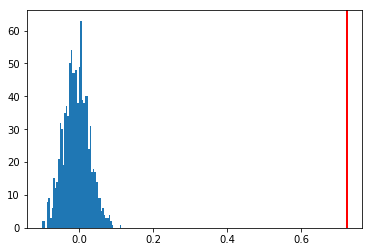

In [20]:
# Use the histogram function to plot the distribution of assortativity coefficients
plt.hist(model_attribute_assortativity, bins=50)

# axvline produces a vertical line at the designated x position on the graph
plt.axvline(attribute_assortativity, lw=2, color="red") #lw = 2 makes the line thicker
plt.show()

## The Political Book Network

Blue = Liberal   
Green = Neutral   
Red = Conservative

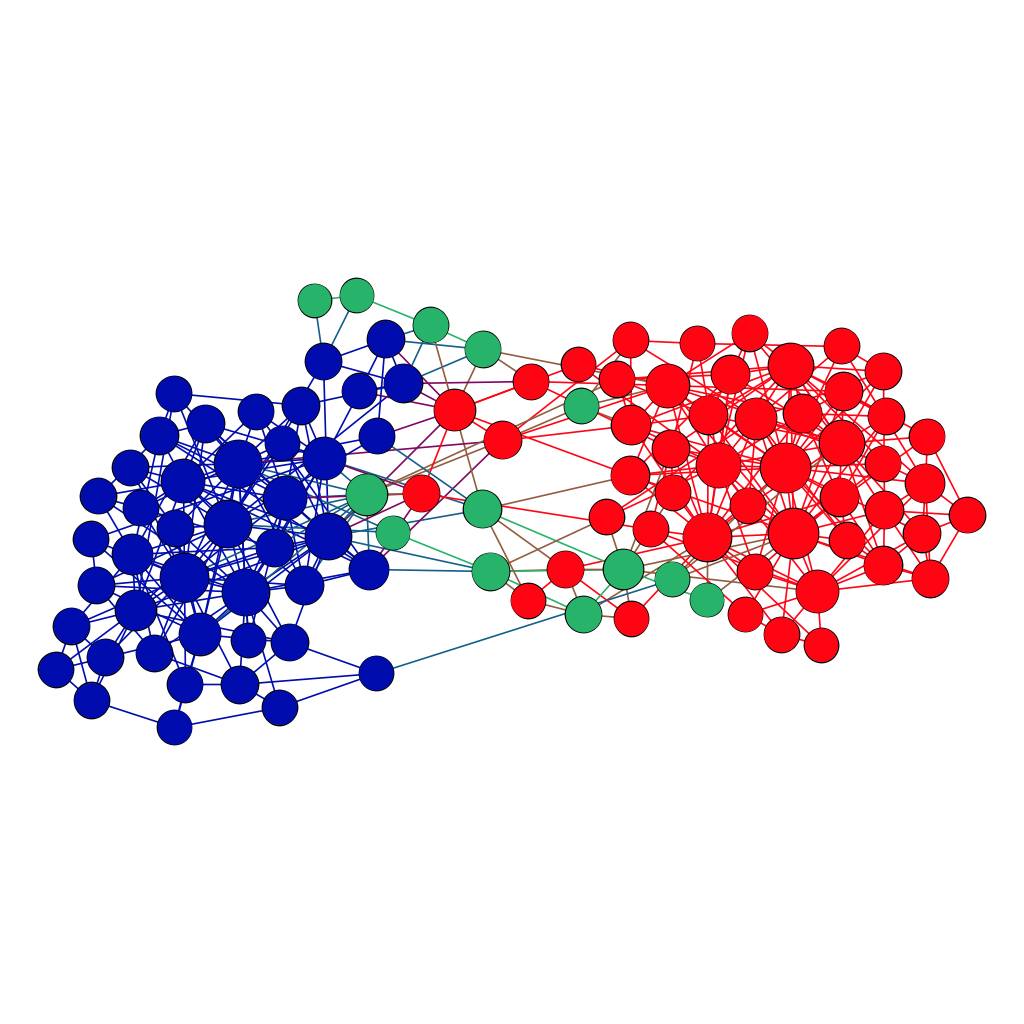

In [27]:
from IPython.display import Image
Image(filename="polbooks.png")